In [1]:
import os
from pathlib import Path
import numpy as np
from tifffile import TiffFile
import suite2p

In [19]:
ROOT_DATA_DIR = "/oscar/data/afleisc2/collab/multiday-reg/data/MS_test"
ANIMAL_ID = 'animal-2457'
DATE_ID = '20230902'
PLANE_ID = 'plane0'

EXP_DIR = Path(ROOT_DATA_DIR) / ANIMAL_ID / DATE_ID
RAW_DIR = EXP_DIR / '0-raw' / PLANE_ID
MOCO_DIR = EXP_DIR / '1-moco' / PLANE_ID
MOCO_FILEPATH = MOCO_DIR / f'{ANIMAL_ID}_{DATE_ID}_{PLANE_ID}_moco.tif'

In [3]:
def get_tiff_list(folder, ext=['.tif', '.tiff']):
    file_list = []
    for x in ext:
        file_list.extend(list(folder.glob(f'*{x}')))
    return file_list

In [4]:
# TEMPORARY ASSUME ONLY 1 TIFF PER PLANE
raw_tiff_files = get_tiff_list(RAW_DIR)
assert len(raw_tiff_files) == 1, 'Currently assume only 1 tiff file per plane'
raw_tiff_path = raw_tiff_files[0]
print(raw_tiff_path)

/oscar/data/afleisc2/collab/multiday-reg/data/MS_test/animal-2457/20230902/0-raw/plane0/2457day00plane0.ome.tif


In [5]:
with TiffFile(raw_tiff_path) as tif:
    num_frames = len(tif.pages)
    page0 = tif.pages[0]
    Ly, Lx = page0.shape

In [6]:
# Suite2p configuration for registration
ops = suite2p.default_ops()

ops.update({
    'do_registration': 1, # DEFAULT
    'two_step_registration': 1.0, # important for registration, esp. for low SNR
    'nimg_init': 1000, # num frames initial to use as reference for registration
    'block_size': [256, 256], # matters for registration
    'nonrigid': True, # important for registration
    'reg_tif': True, # save tiff registration in batches
    'keep_movie_raw': True, # whether to keep raw binary file
    'fs': 5, # estimates across planes
    'combined': False, # whether to combine across planes
    'roidetect': False, # whether to do segmentation after registration
    # 'tau': 0.57, # NOT RELEVANT calcium dynamics for deconv, possibly not correct
    # '1Preg': False, # DEFAULT, not relevant for 2P
    # 'spatial_hp_reg': 42.0, # DEFAULT, not relevant for 2P    
    # 'snr_thresh': 1.2, # DEFAULT, SNR for non-rigid registration 
    # 'maxregshift': 0.1, # DEFAULT, unclear relevance
    # 'maxregshiftNR': 5.0, # DEFAULT, relevant for registration
    # 'smooth_sigma': 1.15, # DEFAULT, relevant for only rigid 
    # 'smooth_sigma_time': 0.0, # DEFAULT, relevant for only rigid 
    # 'maxregshift': 0.1, # DEFAULT, relevant for non-rigid
    # 'reg_tif_chan2': False, # DEFAULT, not relevant, whether to write reg binary of chan2 to tiff file
    # 'pre_smooth': 2.0, # UNCLEAR WHETHER or not relevant for 2p registration, can turn to 0.0
    # 'spatial_scale': 2, # NOT RELEVANT, only for segmentation
    # 'max_iterations': 50, # NOT RELEVANT, only for segmentation
    # 'threshold_scaling': 2.0, # NOT RELEVANT, only for segmentation
    # 'max_overlap': 0.5, # NOT RELEVANT, only for segmentation
    # 'denoise': 1.0, # NOT RELEVANT, only for segmentation
    # 'anatomical_only': 1 # NOT RELEVANT, only for segmentation (whether or not to use cellpose)
})



In [7]:
ops['data_path'] = str(RAW_DIR)
ops['tiff_list'] = [raw_tiff_path]
ops['save_path0'] =  str(MOCO_DIR)

In [8]:
%%time

ops = suite2p.io.tiff_to_binary(ops)

tif
** Found 1 tifs - converting to binary **
NOTE: ScanImageTiffReader not working for this tiff type, using tifffile
2000 frames of binary, time 8.29 sec.
4000 frames of binary, time 15.23 sec.
CPU times: user 5.87 s, sys: 16.7 s, total: 22.6 s
Wall time: 22.1 s


In [9]:
ops

{'suite2p_version': '0.14.2',
 'look_one_level_down': False,
 'fast_disk': '/oscar/data/afleisc2/collab/multiday-reg/data/MS_test/animal-2457/20230902/1-moco/plane0',
 'delete_bin': False,
 'mesoscan': False,
 'bruker': False,
 'bruker_bidirectional': False,
 'h5py': [],
 'h5py_key': 'data',
 'nwb_file': '',
 'nwb_driver': '',
 'nwb_series': '',
 'save_path0': '/oscar/data/afleisc2/collab/multiday-reg/data/MS_test/animal-2457/20230902/1-moco/plane0',
 'save_folder': [],
 'subfolders': [],
 'move_bin': False,
 'nplanes': 1,
 'nchannels': 1,
 'functional_chan': 1,
 'tau': 1.0,
 'fs': 5,
 'force_sktiff': False,
 'frames_include': -1,
 'multiplane_parallel': False,
 'ignore_flyback': [],
 'preclassify': 0.0,
 'save_mat': False,
 'save_NWB': False,
 'combined': False,
 'aspect': 1.0,
 'do_bidiphase': False,
 'bidiphase': 0,
 'bidi_corrected': False,
 'do_registration': 1,
 'two_step_registration': 1.0,
 'keep_movie_raw': True,
 'nimg_init': 1000,
 'batch_size': 500,
 'maxregshift': 0.1,
 'a

In [10]:
f_raw = suite2p.io.BinaryFile(
    Ly=Ly, Lx=Lx, 
    filename=ops['raw_file']
)


In [11]:
%%time

f_reg = suite2p.io.BinaryFile(
    Ly=Ly, Lx=Lx, n_frames = f_raw.shape[0],
    filename = ops['reg_file']
)

CPU times: user 140 µs, sys: 285 µs, total: 425 µs
Wall time: 3.23 ms


In [12]:
%%time

refImg, rmin, rmax, meanImg, rigid_offsets, \
nonrigid_offsets, zest, meanImg_chan2, badframes, \
yrange, xrange = suite2p.registration_wrapper(
    f_reg, 
    f_raw=f_raw,
    f_reg_chan2=None, 
    f_raw_chan2=None, 
    refImg=None, 
    align_by_chan2=False,
    ops=ops
)



Reference frame, 126.73 sec.
Registered 500/5640 in 31.49s
Registered 1000/5640 in 62.63s
Registered 1500/5640 in 88.33s
Registered 2000/5640 in 114.42s
Registered 2500/5640 in 142.23s
Registered 3000/5640 in 171.61s
Registered 3500/5640 in 206.42s
Registered 4000/5640 in 232.51s
Registered 4500/5640 in 257.57s
Registered 5000/5640 in 283.43s
Registered 5500/5640 in 311.24s
Registered 5640/5640 in 318.37s
CPU times: user 13min 48s, sys: 4min 29s, total: 18min 18s
Wall time: 7min 27s


In [ ]:
# too long, longer than writing batches of tiffs
# even after 15 min, still not done
# %%time
# f_reg.write_tiff(MOCO_FILEPATH)

Frame Range: (0, 5640), y_range: (0, 512), x_range(0, 512)


The following are just plots for checking things

In [13]:
from matplotlib import pyplot as plt

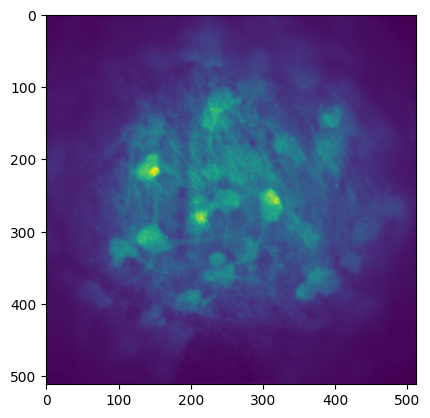

In [14]:
plt.imshow(meanImg)